# The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2018 Semester 1
-----
## Project 1: What is labelled data worth to Naive Bayes?
-----
###### Student Name(s): Ben Tomlin (834198)
###### Python version: 3

This iPython notebook is a template which you may use for your Project 1 submission. (You are not required to use it; in particular, there is no need to use iPython if you do not like it.)

Marking will be applied on the seven functions that are defined in this notebook, and to your responses to the questions at the end of this notebook.

You may change the prototypes of these functions, and you may write other functions, according to your requirements. We would appreciate it if the required functions were prominent/easy to find. 

# Notes to marker:

## Function Locations:
### evaluate()
>This function is in Classifier.evaluate() and is the same for both models.
>The evaluate class method is the first method (for easy access) after the initializer
        
### __init__()/preprocess(), train(), predict()
>Each classifier object has functions in the following order for convenient access
>__init__(), preprocess(), train(), predict()
        
## Run speed
A decision was made to use Pandas DataFrame structures for holding the raw data. This has slowed the implementation down. The larger datasets take 10min to run five iterations of unsupervised training. iloc was used to prevent minimize dict key hashing etc. In hindsight - i would not use Pandas again for heavy processing like this project requires. 

To accomodate for this - the program results have been copied into markdown cells containing answers to the questions. This way you don't need to run the whole program. 

The smaller breast cancer dataset will run quickly so that the code can be tested. Results will differ slightly due to random seeds (unsupervised) and holdout (supervised)

## General Notes
Holdout and add k smoothing were implemented however Q1 and Q7 are the ones answered here. Unknown attribute values are treated as an attribute value '?'. 

There's no need to run all the code as the outputs were copied into the markdown of the answers - though running the code will produce the output used in the answers.

# Preliminaries & Helper Functions
---

This contains utility methods for object creation, manipulation and printing of results - auxillary to the actual project.

In [1]:
# Utility
import csv
import numbers
from collections import defaultdict
from math import exp, log, acos, sqrt, pi
from re import sub

# Dataframes for raw data
import numpy as np
import pandas as p

# Random seeding for unsupervised model
import random

# relative path to folder containing data csv files
dataPath = './'

# Datasets to analyze
dataSet = {
        'breastCancer': {'nClassValue':2,
                         'file':'breast-cancer.csv'},
        'car':          {'nClassValue':4,
                         'file':'car.csv'},
        'hypothyroid':  {'nClassValue':2,
                         'file':'hypothyroid.csv'},
        'mushroom':     {'nClassValue':2,
                         'file':'mushroom.csv'}} 

    
def printComparisionTable(classifierDict):
    """ Print a comparision table for two classifiers given in a dict structure,
    
    Keys of dict structure are printed as identifiers for the clasifier
    """
    
    def _stringifyMetric(m):
        """Turn all metrics to strings for simple printing. (Some could be 'NA'
        others will be floats)"""
        if isinstance(m, numbers.Number):
            return('{:.2f}'.format(m))
        else:
            return(str(m))
                
    COLUMNW = '25'
    WIDTH=str(int(COLUMNW)*3)

    metricTitle = 'Metric Name'
    tableRow = []
    
    classifierType = list(classifierDict.keys())
    
    # Add header row to metric table
    tableRow.append([metricTitle])
    for classifierName in classifierType:
        tableRow[0].append(classifierName)

    # Add metric identifier data to metric table
    rx=1
    metrics = classifierDict[classifierType[0]].metrics[Classifier.CLASSAVERAGE_IDENTIFIER]
    for key in metrics.keys():
        tableRow.append([])
        tableRow[rx].append(key)
        
        for classifierName in classifierType:
            metric = classifierDict[classifierName].metrics[Classifier.CLASSAVERAGE_IDENTIFIER][key]
            tableRow[rx].append(_stringifyMetric(metric))
        rx+=1

    def _printLine():
        print('_'*(int(WIDTH)+7))

    def _printHeader():
        _printLine()
        titleFormat = '|{:^'+str(int(WIDTH)+5)+'}|'
        print(titleFormat.format(classifierDict[classifierType[0]].dataKey.upper()))
        _printLine()
        headerFormat = '| {0[0]:<'+COLUMNW+'s}'+'| {0[1]:<'+COLUMNW+'s}| {0[2]:<'+COLUMNW+'s}|'
        print(headerFormat.format(tableRow[0]))
        _printLine()
    
    # Print table 
    _printHeader()
    
    # Print data
    for ix in range(-1+len(tableRow)):
        rowFormat = '| {0[0]:<'+COLUMNW+'s}| {0[1]:<'+COLUMNW+'s}| {0[2]:<'+COLUMNW+'s}|'
        printRow = rowFormat.format(tableRow[ix+1])
        print(printRow)
    _printLine()
       

def createTrainAndEvaluateClassifier(file, dataKey, nIter = 5, nClassValue=-1):
    """Create, train and evaluate classifiers on a dataset. 
    
    ARGUMENT:
        file - path to dataset
        dataKey - identifier for dataset (used when printing)
        nClassValue - if not -1, create an unsupervised classifier. Else create
                        a supervised classifier. Indicates number of classes to 
                        use for the unsupervised model
                        
    RETURN:
        The resultant classifier
    """

    if nClassValue>0:
        classifier = UnsupervisedNaiveBayes(file, dataKey, nClassValue)
        classifier.train(nIter)

    else:
        classifier = NaiveBayes(file, dataKey)
        classifier.train()


    classifier.evaluate()
    return(classifier)


def prepareClassifiersForSet(key, nIteration=5):
    """Evaluate both classifiers on datasets and print the results
    """
    
    filepath = getDatasetPath(dataSet[key]['file'])
    nClassValue = dataSet[key]['nClassValue']
        
    sModel = createTrainAndEvaluateClassifier(filepath, key)
    uModel = createTrainAndEvaluateClassifier(filepath, key, nClassValue=nClassValue, nIter=nIteration)
    classifierObject[key]["Unsupervised"]=uModel
    classifierObject[key]["Supervised"]=sModel
            

def getDatasetPath(file):
    return(dataPath+file)



# Classifier Class
---
This contains ancestor methods common to both classifiers
>* Raw data management
>* Data preprocessing
>* Data partitioning
>* Evaluation of a model
>* Testing for smoothing requirements
>* Model smoothing logic

In [2]:

class Classifier:
    """Generic container for data used by a classifier
    
    The classifier contains methods for smoothing count data structures and 
    evaluation of models
 
    ---'Raw Data' Structure--- 
    The datasets (training, source, evaluation) are organized in Pandas 
    DataFrames. These have the following structure;
    
    __________________________________________________________________________
    |Index     | Attribute Identifier    | ...        | Class Identifier       |
    __________________________________________________________________________
    |ix        | Attribute Value        | ...        | Class Value           | 
    |ix        | Attribute Value        | ...        | Class Value           | 
    |ix        | Attribute Value        | ...        | Class Value           | 
    |ix        | Attribute Value        | ...        | Class Value           | 
    _________________________________________________________________________|
    

    """
    MARK_ATTR='attr'        #Attribute column identifier
    MARK_CLASS='class'      #Class column identifier 
    DEFAULT_SMOOTHING = 1
    DEFAULT_INITIAL_PARTITION=0.75
    DEFAULT_CLASS_COLUMN=-1
    CLASSAVERAGE_IDENTIFIER = 'Class Average'
    
    def __init__(self, sourcePath, dataKey, hasHeader=False, 
                    initialPartition=DEFAULT_INITIAL_PARTITION,
                    classColumn=DEFAULT_CLASS_COLUMN,
                    smoothingK=DEFAULT_SMOOTHING):
        """Initializes a classifier from source data
         
        Partition raw data and initialize metadata. Place data into DataFrames.

        ARGUMENT
            sourcePath: 
                Absolute or relative path to the csv file containing dataset. 
                
            dataKey: Arbitrary identifier or name for the dataset
                
            hasHeader:
                Indicates whether a header is present in CSV file or not. Header 
                assumed to be first row of the data file. If present, the data 
                frame will use the header as column identifiers.
            
            initialPartition: 
                Fraction of dataset to use as training in initial split.
                
            classColumn:
                Integer column index indentifying the CSV column that holds class
                data.
                
            smoothingK:
                The 'add k' value to use for smoothing. Default is 1.
        """
        # Load data
        self.sourcePath = sourcePath
        self.hasHeader = hasHeader
        self.dataKey = dataKey

        # Wraparound class column index
        self.nCol = self._getColumnCount()
        self.classColumnIndex = (classColumn+self.nCol)%self.nCol
        self.sourceData = self.preprocess()
        
        title = self._getHeader()
        self.classColumnId = title[classColumn]

        # Set of all possible class values
        self.classValue = list(self.sourceData.iloc[:,self.classColumnIndex].unique())

        # Get attribute & feature sets
        self.featureSet = {(ix, title[ix]) for ix in range(len(title))}
        self.attributeSet={(ix,title[ix]) for ix in range(len(title)) if ix != self.classColumnIndex}

        self.model=None             

        # Split source data into samples
        self.trainSample, self.evalSample = self._partitionData(initialPartition)
        
        # Add k value to use if smoothing required
        self.smoothingApplied=False
        self.smoothingK = smoothingK
        self.metrics = None
 

    def preprocess(self):
        """ Load data into pandas dataframe """
        return p.read_csv(self.sourcePath, header=0, names=self._getHeader())
    

    def evaluate(self):
        """Evaluate model and return a dictionary of performance metrics 
                
        RETURN:
            score
                A dictionary with scoring parameters
        """
         
        def _getMetric(prediction, interestingClass):
            """ Return a tuple of (TP, TN, FP, FN) metrics for an evaluation set
            
            Predictions are discrete, that is, they predict one class for each 
            instance. Metrics are measured against an interesting class value,
            which is the class value we are measuring performance against
            
            DEFINITIONS:
                TP - True Positive
                TN - True Negative
                FP - False Positive
                FN - False Negative
                TC - Total Correct classifications
                
            ARGUMENT:
                prediction
                    List of predictions made against the evaluation set. An 
                    assumption is made that the evaluation set is ordered 
                    in the same way as the prediction list. Predictions are 
                    discrete

                interestingClass
                    The class value which we are interested in. Metrics are 
                    calculated against this value. 
                    
            RETURN:
                (TP, TN, FP, FN, TC)
                
            ASSUMPTION:
                *) Prediction is a list with an ordering consistent with 
                    self.evalSample
            """
            
            if (len(prediction) != len(self.evalSample)):
                ValueError('Require the same amount of predictions as samples.')

            TP=TN=FP=FN=TC=0
            for ix in range(self.evalSample.shape[0]):
                instanceClass = self.evalSample.iloc[ix][self.classColumnId]
                predictedClass = prediction[ix]

                TP+=(predictedClass == instanceClass 
                     and predictedClass == interestingClass)

                TN+=(predictedClass != interestingClass 
                     and instanceClass != interestingClass)

                FP+=(predictedClass == interestingClass
                     and instanceClass != interestingClass)

                FN+=(predictedClass != interestingClass
                     and instanceClass == interestingClass)

                TC+=(predictedClass == instanceClass)
                
            return((TP,TN,FP,FN,TC))
       

        def _processMetric(sampleSize, metric):
            """Given a metric tuple, derive performance statistics
            
            ARGUMENT:
                sampleSize = integer size of sample metric applies to
                metric = (TP TN FP FN TC)
                
            RETURN:
                where s = number of instances in sample
                (
                    (BA) Basic Accuracy: TC / s ,
                    (CVA) Class Value Accuracy: (TP + TN) / s , 
                    (CVE) Class Value Error Rate: (FP + FN) /s , 
                    (CVP) Class Value Precision: TP / (TP + FP) , 
                    (CVR) Class Value Recall: TP / (TP + FN) ,
                    (CVF) Class Value FScore: CVP*CVR*2 / (CVP + CVR)
                )
            """ 
            BA = 100*metric[4]/sampleSize
            CVA = 100*sum(metric[0:2])/sampleSize
            CVE = 100*sum(metric[2:4])/sampleSize

            # Get the precision. 'NA' if the classifier made no predictions on the
            # evaluation set for the class of interest.
            if (metric[0]+metric[2])==0:
                CVP='NA'
            else:
                CVP = 100*metric[0]/(metric[0]+metric[2])
                
            # Get recall. If there are no evaluation instances with a particular
            # class then we return an 'NA' value
            if (metric[0]+metric[3])==0:
                CVR='NA'
            else:
                CVR = 100*metric[0]/(metric[0]+metric[3]) 
                
            # Find the F-Score. 'NA' if there is no value available for precision
            # or recall. 'NA' if the precision and recall are zero.
            if CVP=='NA' or CVR=='NA' or (CVR+CVP==0):
                CVF='NA'
            else:
                try:

                    CVF = CVP*CVR*2/(CVP+CVR)
                except ZeroDivisionError:
                    CVF = 'NA'

            return((BA, CVA, CVE, CVP, CVR, CVF))
                

        score = {}


        # Evaluate model against all class values
        for interestingClass in self.classValue:
            prediction = []
            
            # Make predictions on trained model, in order of self.evalSample
            for _, instance in self.evalSample.iterrows():
                predicted = self.predict(instance)
                prediction.append(predicted)
                
            # (TP TN FP FN TC)
            metric = _getMetric(prediction, interestingClass)
            score[interestingClass] = {}

            score[interestingClass]['Smoothing Applied'] = self.smoothingApplied
            score[interestingClass]['True Positive'] = metric[0]
            score[interestingClass]['True Negative'] = metric[1]
            score[interestingClass]['False Positive'] = metric[2]
            score[interestingClass]['False Negative'] = metric[3]
            score[interestingClass]['Total Correct'] = metric[4]

            sampleSize = self.evalSample.shape[0]
            processedMetric = _processMetric(sampleSize, metric)

            score[interestingClass]['Basic Class Value Accuracy'] = processedMetric[0]
            score[interestingClass]['Class Value Accuracy'] = processedMetric[1]
            score[interestingClass]['Class Value Error Rate'] = processedMetric[2]
            score[interestingClass]['Class Value Precision'] = processedMetric[0]
            score[interestingClass]['Class Value Recall'] = processedMetric[4]
            score[interestingClass]['Class Value F-Score'] = processedMetric[5]
            

        # Average performance for the class
        score[self.CLASSAVERAGE_IDENTIFIER] = {}
        for processedMetricName in ['Basic Class Value Accuracy',
                           'Class Value Accuracy',
                           'Class Value Error Rate',
                           'Class Value Precision',
                           'Class Value Recall',
                           'Class Value F-Score']:
            
            # List of all metric values for a given processed metric
            metricValues = [score[iClass][processedMetricName] for iClass 
                            in score.keys() if iClass != self.CLASSAVERAGE_IDENTIFIER]

            # The average is undefined if the metric has any 'NA' values
            if len([x for x in metricValues if type(x) is str])>0:
                metricAverage='NA'

            # Average all values for the metric
            else:
                metricAverage=(sum(metricValues)/len(metricValues))

            # Put average metric score into our score structure
            score[self.CLASSAVERAGE_IDENTIFIER][sub(r'Value ','',processedMetricName)]=metricAverage
                                    
        self.metrics=score

        return(score)


    def _getColumnCount(self):
        """Return number of class and attribute columns"""
        with open(self.sourcePath) as file:
            return len(next(csv.reader(file)))
  

    def _partitionData(self, trainingPortion):
        """Shuffle and partition classifier dataset into two partitions
        
        Return tuple of two DataFrames, the first the training set and the second
        the evaluation set. 
        
        ARGUMENT
            trainingPortion - the portion of the the dataset that will be 
            returned as the first element of the return tuple. The other element
            will be the remainder.
                
        RETURN
            (trainingPartition, evaluationPartition)
        """
        
        if (trainingPortion < 0 or trainingPortion > 1):
            raise ValueError('Tried to partition dataset with non fractional \
                                            portion {}'.format(trainingPortion))

        nInstance = self.sourceData.shape[0]
        nTrain = (int)(nInstance * trainingPortion)
        shuffleIndex = np.random.permutation(nInstance)

        trainSample = self.sourceData.iloc[shuffleIndex[0:nTrain]]
        evalSample = self.sourceData.iloc[shuffleIndex[nTrain:nInstance]]

        return((trainSample,evalSample))
 

    def _getHeader(self):
        """Return list of data column titles. 

        Return list of numeric column titles for a given CSV file. 
        Titles start from one and are labeled "attrN". A CSV file will have;

            o = m + n columns
            n attribute columns
            m class columns 
        """
            
        xAttr=0
        xClass=0
        title=[]

        # Build column headings
        for ix in range(self.nCol):

            # Discern column type
            if (ix == self.classColumnIndex):
                mark=self.MARK_CLASS
                counter=xClass
                xClass+=1
            else:
                mark=self.MARK_ATTR
                counter=xAttr
                xAttr+=1
                
            title.append("{}{}".format(mark,counter))

        return(title)


    def smoothingRequired(self, count, classValueList):
        """Given count, check there are no zero count attribute values
        
        Attribute value counts are for a given class value priors. Check against
        all known attribute and class values
        
        ARGUMENT:
            count - A structure holding prior and posterior probabilities 
            
            { classValue: [ classValuePrior, attrData ] }
            
                attrData =
                { attrId: { attrValue: attrPosterior (given classValue) } }
                
            classValueList - list of class values to verify the count dstr for.
        
        RETURN:
            True - if a zero count exists
            False - otherwise
        
        ASSUMPTION:
            *) All of the possible values for a class are represented in the 
                training set - this is checked by __init__()
        """
        
        # Check there is an instance for every attribute value seen in the 
        # source dataset given a some posterior class value
        for classValueX in classValueList:
            for _,attrId in self.attributeSet:
                
                seenAttributeValue = set(self.sourceData[attrId].unique())
                
                for aValue in seenAttributeValue:
                
                    # Check every seen attribute value is represented in this class
                    if count[classValueX][1][attrId][aValue] == 0:
                        return(True)
        return(False)
           

    def getSmoothedModel(self, count, k=DEFAULT_SMOOTHING):
        """Yield a natural log transformed probability model with add k smoothing. 
        
        Add k to all attribute value posteriors in count. Mutates count into 
        model. Count can be cumulative probabilities also
        
        ARGUMENT:
            count - count structure from which to derive a model
            
                Count has the following structure;
                    
                    { classValue: [ valueCount, attributeData ] }
                    
                    attributeData;
                        { attributeId: attributeValueData }
                        
                        attributeValueData;
                            { attributeValue: attribute posterior count }

            k - value of k to add for smoothing
            
        RETURN:
            Mutate count into log transformed probability model for NB classifier. 

                { classValue: [ valueProbability, attributeData ] }
                
                attributeData;
                    { attributeId: attributeValueData }
                    
                    attributeValueData;
                        { attributeValue: posterior probability }
                        
        NOTE:
            All probabilities are natural log transformed. This happens here for 
            optimization reasons. Predictions only require log transformed 
            probabilities. Model evaluation only requires predictions.
            
            The prediciton code is hammered for evaluation and general object
            usage. Thus its calculation overhead is minimized with a 
            transformed model for optimality.
        """

        # Check k is valid
        if (k>1 or k<0):
            raise ValueError("k must be [0, 1] for smoothing. {} given".format(k))
        
        nInstance = sum([x[0] for x in count.values()])
        
        # For class values of a given class
        for _, classValueData in count.items():
            
            # Convert class value count to probability
            classValueFreq = classValueData[0]
            classValueData[0]/=nInstance
            
            # Apply transform to class value count
            classValueData[0]=log(classValueData[0])

            # Add k to all attribute value counts for all seen attribute 
            # values of a given attribute.
            for _,attrId in self.attributeSet:

                seenAttributeValue = set(self.sourceData[attrId].unique())
                
                for attrValue in seenAttributeValue:
                
                    # Divisor is number of instances for the prior 
                    # (ie the class value) plus the product of k and the 
                    # number of k additions (ie, the number of unique 
                    # attribute values for the given attribute)
                    divisor = classValueFreq + (len(seenAttributeValue)*k)

                    # Convert to attribute value counts to add k probabilities
                    classValueData[1][attrId][attrValue]+=k
                    classValueData[1][attrId][attrValue]/=divisor

                    # Apply transform to posterior probabilities
                    classValueData[1][attrId][attrValue] = log(classValueData[1][attrId][attrValue])
            

    def getClassDistribution(self, dataSet):
        """Return a vector indicating the ratios of each class value for dataset
        
        ARGUMENT:
            dataSet - A pandas dataframe containing data to analyze
            
        RETURN:
            A sorted list of tuples. The first element of each tuple is the ratio, 
            the second element is the class value which the ratio represents. 
            The list is sorted in order of ratios
            
        NOTE:
            This only applies to datasets that have a class column corresponding
            with label corresponding to self.classColumnId
            
        """


        nItem = dataSet.shape[0]
        distributionMap = []

        # Find ratio for each class value
        for classValue in self.classValue:
            classRatio = sum(dataSet[self.classColumnId]==classValue)/nItem
            distributionMap.append((classRatio, classValue))
            
        distributionMap.sort(key = lambda x: x[0])
        return(distributionMap)
 

# Naive Bayes Class
---
This contains methods specific to NB
>* Training logic
>* Prediction logic


In [3]:

class NaiveBayes(Classifier):
    """Class abstracting Naive Bayes class prediction model
    :
    Contains and maintains a data model used for prediction, and a structure
    containing raw data. This class is responsible for interacting with the 
    classifier model. (Making predictions, updating model, evaluating model etc)

    --- 'model' DataStructure ---
    The output of training, this contains all of the information required to 
    make a prediction for an instance

        { Class Value:
            [ Probability(Class Value), 
              Attribute Value Posterior Probabilities (for class value) 
            ]
        }
        
        ---'Attribute Value Posterior Probabilities' DataStructure---
        
        { Attribute Identifier:
            { Attribute Value:
                Attribute Value Posterior Probability
            }
        }
        
          
    ---'Data Features'---
    The available features tracked by an attribute, class and feature set. The 
    feature set is the union of the class and attribute sets. Each of these are 
    encapsulated in the following structures for targeted access to 'Raw Data'

        #    feature - class or  attribute of data
        #    class   - some classification of a data instance 
        #    attribute - some feature of a data instance that is  not a class
    
    [ (Feature DataFrame Column Index, Feature Identifier), ... ] 
    
    The Feature Identifier could be a class or attribute column identifier
    """


    def __init__(self, sourcePath, dataKey,
                    hasHeader=False,
                    initialPartition=Classifier.DEFAULT_INITIAL_PARTITION,
                    classColumn=Classifier.DEFAULT_CLASS_COLUMN,
                    smoothingK = Classifier.DEFAULT_SMOOTHING):
        """ Initialize classifier and class metadata. Check training data valid
        
        See parent initializer for arguments not presented here. 

        Valid training data passes the following: Check the training partition 
        contains all of the class values seen in the data set. Raise an error 
        if not. 

        ARGUMENTS
            As per the Classifier class initializer docstring

            classColumn:
                Integer indicating the CSV class column index. Negative 
                values count from the last column. (-1 : last column ) etc
                
            smoothingK:
                some value in [0,1] for add k smoothing.
       """
        
        Classifier.__init__(self, sourcePath, dataKey,
                            hasHeader,
                            initialPartition,
                            classColumn,
                            smoothingK)


        def _checkTrainingSampleHasAllClassValue():
            """Asserts the classifiers training sample contains all class values
            """
            if self.trainSample is None: 
                raise ValueError("Sample needs to be partitioned")
            
            sampleClassValue=set(self.trainSample[self.classColumnId].unique())
            if sampleClassValue != set(self.classValue):
                raise ValueError('Not all possible class values are represented\
                                    in the training data partition. Get more \
                                    source data or try a different paritioning \
                                    strategy.')

        # Ensure the training sample has all class values represented
        _checkTrainingSampleHasAllClassValue()
        

    def predict(self, instance):
        """Predicts the class of valid given instance
        
        A valid instance has some value for each non-class attribute. 
        A valid instance does not contain any unseen attribute 
        value (all attribute values in the supplied source data set are 'seen')
        
        It may or may not contain class data - which will be ignored. 
        
        Prediction made with log transformed Naive Bayes formula;
            
            for all c
            max( c ): p(c) * p(x1|c) * p(x2|c) * p(x3|c) * ... * p(xi|c)
            
            or, transformed;
            max( c ): log(p(c)) + log(p(x1|c)) + ... + log(p(xi|c))

            where c is some class value
            
        ARGUMENT:
            instance - valid instance for which a prediction is to be made. 
            A Pandas series with column keys that are consistent with 
            self.featureSet column identifiers
            
        RETURN:
            Returns the class with the greatest value as per the above formula
            Return None if the instance was invalid
            
        ASSUMPTION:
            *) The model's probabilities are assumed to be log transformed.
            
        NOTE: 
            See self.train() for rationale of a log transformed model.
            
        """
        
        model = self.model 
        predictedClass = None
        maxScore = None
            
        # Probabilities for each class value
        for classValue, cData in model.items():

            score = cData[0]
            
            # Product of class value posteriors for each attribute of the instance
            for _,attrId in self.attributeSet:
                instanceAttrValue = instance[attrId]
                
                # Assuming the model is log transformed, product becomes a sum
                score += cData[1][attrId][instanceAttrValue]
                
            if (maxScore is None) or (score>maxScore):
                maxScore=score
                predictedClass = classValue
                
        return(predictedClass)
      
      
    def train(self):
        """Build model from the training dataset
        """

        def _countOccurence():
            """Count class value and attribute value (given a class value) occurences
            
            Always returns a valid count datastructure. See _validateCount()
            
            RETURN:
                Count data structure;
                    { classValue:
                        [classValueCount, classValueData] }
                        
                ----classValueData structure;
                        { attrId: attrData }
                        
                ----attrData structure;
                        { attrValue: count }
            """


            def _validateCount(count):
                """Asserts the count structure is valid. Raise a value error if not
                
                A valid count structure is such that;
                
                    A -> for every given class, the sum of class value counts is 
                        equal to the number of training instances
                        
                    B -> for every given class value, the sum of attribute value
                        counts for any given attribute and some given class value 
                        is such that it is equal to the occurence count of the
                        posterior class value
                        
                RETURN:
                    true if variable count is a valid structure
                """
                
                # Check condition A
                sumCountInstance = sum([x[0] for x in count.values()])
                if sumCountInstance != self.trainSample.shape[0]:
                    raise ValueError('Model size not consistent with training set')
                
                # Check condition B
                for classValue in count.keys():
                    classValueCount = count[classValue][0]

                    for attrId in count[classValue][1].keys():

                        totalAttrValueCount = sum(count[classValue][1][attrId].values())
                        if totalAttrValueCount != classValueCount:
                            raise ValueError('Attribute counts not for class value')
                return


            nInstance = self.trainSample.shape[0]

            # count;            { classValue: [valueCount, valueData] }
            # (class)valueData; { attrId: attrData }
            # attrData;         { attrValue: (int)count }
            count = defaultdict(lambda: [0, defaultdict(lambda: defaultdict(int))])
            # Count instances
            for ix in range(nInstance):

                classValue = self.trainSample.iloc[ix, self.classColumnIndex]

                # Count class value occurence 
                count[classValue][0]+=1
                
                # Count attribute value occurence for a given class value
                for attrIndex, attrId in self.attributeSet:
                    attrValue = self.trainSample.iloc[ix,attrIndex]
                    count[classValue][1][attrId][attrValue]+=1
                    
            _validateCount(count)
            return(count)

       
        # Check a train sample was partitioned
        if self.trainSample is None:
            raise ValueError('Partition a training sample before training')

        count = _countOccurence()
        
        # Apply smoothing if required
        smoothingK = 0 # Default no smoothing
        if self.smoothingRequired(count,self.classValue):
            self.smoothingApplied=True
            smoothingK = self.smoothingK
        
        # Yield  model from counts
        self.getSmoothedModel(count,smoothingK)
        self.model=count






# Unsupervised Classifier Class
---
Contains unsupervised specific logic related to;
* Seeding probabilities
* Probability predictions
* Discrete predictions from probability predictions
* Iterative model refinement (part of training)
* Model training metrics

In [4]:

class UnsupervisedNaiveBayes(Classifier):
    """Class for creating, manipulating and evaluating UNB classifier 
 
    The unsupervised classifier uses a labelled evaluation set and and unlabelled
    training set. A model is built from the unlabelled set and seeded with 
    random class probabilities. The model is then iteratively refined by 
    predicting class values for all training set instances and then 
    being recalculated on the updated training set. 

    --- 'model' DataStructure ---

    The output of training, this contains all of the information required to 
    make a prediction for an instance

        { Class Value:
            [ Probability(Class Value), Attribute Value Posterior Probabilities (for class value) ]
        }
        
        ---'Attribute Value Posterior Probabilities' DataStructure---
        
        { Attribute Identifier:
            { Attribute Value:
                Attribute Value Posterior Probability
            }
        }
        
    There is only one Class in the model typically
 
    ---'Raw Data' Structure--- 
    The datasets (training, source, evaluation) are organized in Pandas DataFrames. These have the following structure;
    
    __________________________________________________________________________________________
    |Index     | Attribute Identifier    | ...        | Class Value Identifier    | ...        |
    __________________________________________________________________________________________
    |ix        | Attribute Value        | ...        | Probability for value    | ...        |
    |ix        | Attribute Value        | ...        | Probability for value    | ...        |
    |ix        | Attribute Value        | ...        | Probability for value    | ...        |
    |ix        | Attribute Value        | ...        | Probability for value    | ...        |
    __________________________________________________________________________________________
    
    
    ---'Data Features'---
    The available features tracked by an attribute, class and feature set. The feature set is 
    the union of the class and attribute sets. Each of these are encapsulated in the following
    structures for targeted access to 'Raw Data'
    
    [ (Feature DataFrame Column Index, Feature Identifier), ... ] 
    
    The Feature Identifier could be a class value identifier or an attribute identifier
    """
    
    #Sets bound on the minimum possible probability any class value can have for
    #any instance when randomly seeding probabilities into training data.
    EPSILON=0.001
    DEFAULT_ITERATIONS = 5


    def __init__(self, sourcePath, dataKey, nClassValue, 
                    hasHeader=False, 
                    initialPartition=Classifier.DEFAULT_INITIAL_PARTITION,
                    classColumnIndex=Classifier.DEFAULT_CLASS_COLUMN,
                    smoothingK=Classifier.DEFAULT_SMOOTHING):
        """Prepare and validate training data structure. Randomly seed class probabilities.
        
        Add a column for each possible class value to the training data frame
        to hold class value probabilities.

        ARGUMENT:
        See parent 'Classifier' class for parent args

            nClassValue
                This is the number of class values the unsupervised classifer 
                will use to make predictions. There should be as many of these
                as there are known class values. See train for how class values 
                are mapped. 
                
                If this is not consistent with how many class values are known
                about, a ValueError will be raised.
                
        """
        Classifier.__init__(self, 
                            sourcePath, dataKey,
                            hasHeader,
                            initialPartition,
                            classColumnIndex)
        
        self.nClassValue = nClassValue
        
        # Remove the class column form the training sample (unsupervised)
        self.trainSample.drop(self.classColumnId, axis=1, inplace=True)
        

        # Track indices and id's of class value columns
        self.classSet = list()

        # Enumerate columns for class values and add them into our training data
        for ix in range(nClassValue):
            className = Classifier.MARK_CLASS+str(ix)
            classColumnIndex = self.trainSample.shape[1]
            self.classSet.append((classColumnIndex,className))
            self.trainSample.loc[:,className]=p.Series()
        
        # Seed training data class columns with noise
        self._randomSeed()
        
        # This holds a map between class columns and actual classes. This is
        # set once the model has trained
        self.classMap = None
        self.trainingMetrics=None
                 

    def train(self, nIter = DEFAULT_ITERATIONS):
        """Refine the model by training iteratively
        
        Make a prediction for each class value of every instance in the 
        training set. Normalize the result such that the sum of probabilities 
        across all class values sums to one.
        
        Recreates model with new resultant training set and scores it with the
        following metrics;

            1) Certainty: sum of all dominant class value probabilities divided
                by the number of training instances. Certainty should increase 
                over iterations
                
            2) ClassDistributionVector dTheta: The change in the class distribution
                vector direction. This reflects the distribution of class values
                over the training set. This should stabilize after some iteration
                
                dot(a,b) = abs(a)abs(b)cos(th)
                    th = acos(dot(a,b)/(abs(a)abs(b)))
                    
                    dTheta = th1 - th0 [rad]
                    
        ARGUMENT:
            nIter
                Number of iterations to train the model for
                
        RETURN:
            A dictionary with each key being an iteration number. The value for 
            each key contains the two metrics presented above.

        """
        def _getClassDistributionVector():
            """Return unit normal class distribution vector """
            v = []
            for _,cId in self.classSet:
                v.append(self.model[cId][0])
            return v
        

        def _getTheta(u, v):
            """Return theta, angle between two ndim vectors"""
            if(len(u)!=len(v)):raise ValueError("Cannot get dTheta for vectors of \
                inconsistent dimension")
            
            def _dot(q,r):
                """Return dot product of two n dim vectors"""
                prod = 0
                for ix in range(len(q)):
                    prod+=(q[ix]*r[ix])
                return(prod)
                    
            def _abs(s):
                """Return magnitude of a vector"""
                summand=0
                for si in s:
                    summand+=pow(si,2)
                return(sqrt(summand))

            return((acos(_dot(u,v)/(_abs(u)*_abs(v))))/pi)


        def _getCertainty(prediction):
            """Return the certainty of a set of predictions """
            summand=0
            for ix in range(len(prediction)):
                summand+=max(prediction[ix].values())
            return(summand/len(prediction))
                

        # Derive model from randomly seeded training data set
        self._trainOnData()
        prediction = {}
        modelMetric = {}

        # Iteratively refine model
        trainSample = self.trainSample
        for rx in range(nIter):
            
            # Get class distribution vector from the current model
            priorClassDistributionVector = _getClassDistributionVector()
            
            # Make predictions for training set with current model
            for ix in range(trainSample.shape[0]):
                
                instance = trainSample.iloc[ix]
                prediction[ix]=self._normalizedProbabilityPredict(instance)
                
                # Update the training dataframe with new prediction
                for classIndex, classValue in self.classSet:
                    trainSample.iloc[ix,classIndex]=prediction[ix][classValue]
                
            # Train/derive model from updated training dataset
            self._trainOnData()
            nextClassDistributionVector = _getClassDistributionVector()
                
            modelMetric['Iteration {}'.format(rx+1)]={}
            modelMetric['Iteration {}'.format(rx+1)]["Certainty [%]"] = _getCertainty(prediction)
            modelMetric['Iteration {}'.format(rx+1)]["Class Distribution Delta [deg]"] = _getTheta(
                priorClassDistributionVector,
                nextClassDistributionVector)
            
        # Map unidentified class values to actual class values
        self.trainingMetrics=modelMetric
        self.classMap = self._mapClassValues(nextClassDistributionVector)

        return modelMetric

         
    def predict(self,instance):
        """Return the predicted class value with the highest probability"""
        prediction = self._probabilityPredict(instance)
        maxClass = max(prediction.items(), key=lambda x:x[1])[0]
        return(self.classMap[maxClass])


    def _normalizedProbabilityPredict(self, instance):
        """Predicts an instance with model. Return dict of probabilities
        
        Normalized such that the sum of all class value predictions for the 
        instance add to 1.
        
        ARGUMENT:
            instance - An instance having only previously seen attribute values
        
        RETURN:
            A dictionary with keys being the available class values column 
            identifiers, and values being the probability of the instance having that value
            
        ASSUMPTION:
            Assumes the model is natural logarithm transformed
        """


        def _normalizeClassValueScore(classScore):
            """Recover normalized probabilities from log transformed ones.
            
            Given a dictionary with class value keys, and log transformed 
            probability values.
            
            THEORY: 
                If the Naive Bayes probabilities are;
                    score=p(classValue) 
                    score*=p(ai | classValue) for all i in [i0.. iN] 
                    
                    such that p(instance is classValue) = score
                    
                And the score vector is log transformed such that
                    logScore=log(p(classValue))
                    logScore+=log(p_i) for all i in [i0 .. iN]
                    
                    where p_i is a score for some class value
                    
                Then the percentage ratio of each class value (ie class value 
                predictions) are as follows;
                    p(classValueNorm) for given instance
                        = exp(logScore for given class value)
                            / sum(exp(logScore) for all class values)
            """
            
            # Convert to normalized probability
            totalSum = sum([exp(x) for x in classScore.values()])
            for classValue, classValueScore in classScore.items():
                classScore[classValue]= exp(classValueScore)/totalSum
        classScore = self._probabilityPredict(instance)
        _normalizeClassValueScore(classScore)    

        return(classScore)
        

    def _probabilityPredict(self, instance):
        """Predicts an instance with model. Return dict of probabilities
        
        This prediction uses a log transformed model and does not revert the 
        transform in it's predictions. This is for quicker evaluation of the
        
        ARGUMENT:
            instance - An instance having only previously seen attribute values
        
        RETURN:
            A dictionary with keys being the available class values column 
            identifiers, and values being the probability of the instance having that value
            
        ASSUMPTION:
            Assumes the model is natural logarithm transformed
        """

        if self.model is None:
            raise ValueError("Train classifier before using it to make predictions")
        
        classScore = {}
        
        # Score each possible class value
        for cx in range(self.nClassValue):

            classValue = self.classSet[cx][1]
            
            # Probability an instance will be 'classValue'
            classValueScore = self.model[classValue][0]
            
            # Get product of all posteriors (n attributes, and nxm attribute values)
            for attrIndex, attrId in self.attributeSet:
                attrValue = instance[attrIndex]
                classValueScore+=self.model[classValue][1][attrId][attrValue]
                
            classScore[classValue]=classValueScore
        return(classScore)

           
    def _randomSeed(self):
        """Seeds the class values of each training item with a random probability 
        
        The sum of all training item class value probabilities is be 1. 
        
        Probabilities will be generated by randomly bisecting the remaining 
        probability quota for each class value available. For example, 

            probabilityQuota = 1
            classValueX-1 = rand(0,probabilityQuota) 
            prbabilityQuota -= classValueX-1
            classValueX = rand(0, probabilityQuota)
            so on
            ...
            
        The order in which class values will be assigned will also be randomized. 
        This is done to accomodate the "diminishing probability quota" forcing
        lower ordinal class values from assuming higher probability sums.
        
        NOTE:
            Seeding will be such that no class value is seeded with zero 
            probability. The margin for this will be set by self.EPSILON
        """
        nTrain = self.trainSample.shape[0]
        
        # Seed every instance
        for ix in range(nTrain):
            probabilityQuota = 1
            classCount = 0

            # Seed class columns in a random order for every instance
            for cx in np.random.permutation(range(self.nClassValue)):
                classColumn = self.classSet[cx][0]
                
                # Assign quota remainder to final class value probability
                if classCount == (self.nClassValue - 1):
                    self.trainSample.iloc[ix, classColumn] = probabilityQuota

                # Assign random bisection of class value quota to probability
                else:
                    # Epsilon ensures that no class value will be seeded with
                    # zero probability
                    probability = random.uniform(0+self.EPSILON, 
                                                 probabilityQuota-self.EPSILON)
                    self.trainSample.iloc[ix, classColumn] = probability

                probabilityQuota -= probability
                classCount+=1


    def _mapClassValues(self, classDistributionVector):
        """Maps model's unidentified class values to actual class values. 
        
        Mapping is based on the class distribution. The class distribution of 
        the iteratively classified training set is matched with the distribution
        of the evaluation data set. The identity of a class value in the 
        unsupervised model is the identity of a class value in the evaluation 
        training set that has the closes matching distribution.
        
        INPUT:
            classDistributionVector - Vector with elements corresponding to 
            the occurence ratio of a class column in the training data set. 
            Ordering of elements as per ordering of self.classSet
            
        OUTPUT:
            A dictionary 
             { realClassIdentity: trainingSetUnidentifiedClassValueColumnName }
        """
        classMap = {}
        
        # Get actual class distribution
        actualClassDistribution = self.getClassDistribution(self.sourceData)
        
        # Build training class distribution/class value id pair list
        trainingDistribution = [(classDistributionVector[ix], self.classSet[ix][1]) for ix in range(len(classDistributionVector))]
        
        # Sort the training distribution class value column id's in distribution order
        trainingDistribution.sort(key=lambda x: x[0])
        
        if len(trainingDistribution) != len(actualClassDistribution):
            raise ValueError('The unsupervised model needs to have the same number of class values as the dataset')
        
        for ix in range(len(trainingDistribution)):
            classMap[trainingDistribution[ix][1]]=actualClassDistribution[ix][1]
            
        return(classMap)
        

    def _trainOnData(self):
        """Train the model on the current training dataset

        Fill "count" data structure containing posterior and class counts
        
        Apply smoothing if necessary and convert to a log transformed model.
        
        
        RETURN:
            Update model of self.

        """
        
        def _accumulateProbabilities():
            """Accumulate probabilities for class and attribute values
            
            Analogous to counting for the supervised NB classifier, accumulate
            probabilities for each class value and each attribute value given
            a class value.
            
            RETURN:
                data structure with same structure as the model. However, 
                contains cumulative probabilities

            """
            
            
            # Model data structure as per class docstring
            cumulateModel = defaultdict(lambda: 
                                        [0, defaultdict(lambda: 
                                                        defaultdict(int))])

            nTrainingInstance = trainSample.shape[0]

            # Cumulate probabilities instance by instance 
            for ix in range(nTrainingInstance):
                
                # For each class value
                for classIndex, classId in self.classSet:

                    # For the unsupervised model, a column represents the class 
                    # value. Thus the class value is the class id
                    classValue = classId
                    classValueProbability = trainSample.iloc[ix, classIndex]

                    # Class value total probability, and total instances
                    cumulateModel[classValue][0]+=classValueProbability
                
                    # Cumulate attribute value posteriors
                    for attrIndex, attrId in self.attributeSet:
                        attrValue = trainSample.iloc[ix,attrIndex]
                            
                        # Attribute value probability given class value
                        cumulateModel[classValue][1][attrId][attrValue] \
                                        +=classValueProbability
            
            return cumulateModel
             
        trainSample = self.trainSample

        # The __init__() call should have intialized a training data set. 
        # to continue. Check it is available.
        if trainSample is None:
            raise ValueError('Tried to train with no training sample initialized.')

        
        # Train
        model = _accumulateProbabilities()
     
        # Apply smoothing to cumulate probability count model if required
        smoothingK = 0
        if self.smoothingRequired(model, model.keys()):
            self.smoothingApplied=True
            smoothingK = self.smoothingK
        
        # Yield smoothed, log transformed model from counts
        self.getSmoothedModel(model,smoothingK)

        self.model = model



In [5]:
# A global variable to hold the results of our calculations below
classifierObject=defaultdict(dict)

In [6]:
prepareClassifiersForSet('breastCancer',5)

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/lib/python3.6/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] =

In [7]:
printComparisionTable(classifierObject['breastCancer'])

__________________________________________________________________________________
|                                  BREASTCANCER                                  |
__________________________________________________________________________________
| Metric Name              | Unsupervised             | Supervised               |
__________________________________________________________________________________
| Basic Class Accuracy     | 63.89                    | 72.22                    |
| Class Accuracy           | 63.89                    | 72.22                    |
| Class Error Rate         | 36.11                    | 27.78                    |
| Class Precision          | 63.89                    | 72.22                    |
| Class Recall             | 60.50                    | 65.93                    |
| Class F-Score            | 59.37                    | 66.39                    |
__________________________________________________________________________________


# Unsupervised Breast Cancer - Per Class Value Metrics

In [14]:
pp.pprint(classifierObject['breastCancer']['Unsupervised'].metrics)

classifierObject.keys()


{   'Class Average': {   'Basic Class Accuracy': 45.833333333333336,
                         'Class Accuracy': 45.833333333333336,
                         'Class Error Rate': 54.166666666666664,
                         'Class F-Score': 44.00797607178465,
                         'Class Precision': 45.833333333333336,
                         'Class Recall': 45.20851818988465},
    'no-recurrence-events': {   'Basic Class Value Accuracy': 45.833333333333336,
                                'Class Value Accuracy': 45.833333333333336,
                                'Class Value Error Rate': 54.166666666666664,
                                'Class Value F-Score': 54.11764705882353,
                                'Class Value Precision': 45.833333333333336,
                                'Class Value Recall': 46.93877551020408,
                                'False Negative': 26,
                                'False Positive': 13,
                                'Smoothing Applie

dict_keys(['breastCancer'])

In [57]:
prepareClassifiersForSet('car',5)

5
-1
10
4


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/lib/python3.6/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] =

In [62]:
printComparisionTable(classifierObject['car'])

__________________________________________________________________________________
|                                      CAR                                       |
__________________________________________________________________________________
| Metric Name              | Unsupervised             | Supervised               |
__________________________________________________________________________________
| Basic Class Accuracy     | 35.42                    | 83.33                    |
| Class Accuracy           | 67.71                    | 91.67                    |
| Class Error Rate         | 32.29                    | 8.33                     |
| Class Precision          | 35.42                    | 83.33                    |
| Class Recall             | 25.14                    | 53.04                    |
| Class F-Score            | 21.97                    | 56.05                    |
__________________________________________________________________________________


In [45]:
prepareClassifiersForSet('hypothyroid',5)

5
-1
10
2


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/lib/python3.6/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] =

In [48]:
printComparisionTable(classifierObject['hypothyroid'])

__________________________________________________________________________________
|                                  HYPOTHYROID                                   |
__________________________________________________________________________________
| Metric Name              | Unsupervised             | Supervised               |
__________________________________________________________________________________
| Basic Class Accuracy     | 88.24                    | 95.20                    |
| Class Accuracy           | 88.24                    | 95.20                    |
| Class Error Rate         | 11.76                    | 4.80                     |
| Class Precision          | 88.24                    | 95.20                    |
| Class Recall             | 45.68                    | 49.93                    |
| Class F-Score            | NA                       | NA                       |
__________________________________________________________________________________


In [1]:
prepareClassifiersForSet('mushroom',5)

NameError: name 'prepareClassifiersForSet' is not defined

In [63]:
printComparisionTable(classifierObject['mushroom'])

__________________________________________________________________________________
|                                    MUSHROOM                                    |
__________________________________________________________________________________
| Metric Name              | Unsupervised             | Supervised               |
__________________________________________________________________________________
| Basic Class Accuracy     | 48.10                    | 95.77                    |
| Class Accuracy           | 48.10                    | 95.77                    |
| Class Error Rate         | 51.90                    | 4.23                     |
| Class Precision          | 48.10                    | 95.77                    |
| Class Recall             | 48.12                    | 95.65                    |
| Class F-Score            | 48.09                    | 95.75                    |
__________________________________________________________________________________


In [ ]:
pprint(classifierObject['hypothyroid']['Unsupervised'].metrics)

In [53]:
classifierObject['hypothyroid']['Supervised'].metrics


{'Class Average': {'Basic Class Accuracy': 95.19595448798988,
  'Class Accuracy': 95.19595448798988,
  'Class Error Rate': 4.804045512010114,
  'Class F-Score': 'NA',
  'Class Precision': 95.19595448798988,
  'Class Recall': 49.93368700265252},
 'hypothyroid': {'Basic Class Value Accuracy': 95.19595448798988,
  'Class Value Accuracy': 95.19595448798988,
  'Class Value Error Rate': 4.804045512010114,
  'Class Value F-Score': 'NA',
  'Class Value Precision': 95.19595448798988,
  'Class Value Recall': 0.0,
  'False Negative': 37,
  'False Positive': 1,
  'Smoothing Applied': True,
  'Total Correct': 753,
  'True Negative': 753,
  'True Positive': 0},
 'negative': {'Basic Class Value Accuracy': 95.19595448798988,
  'Class Value Accuracy': 95.19595448798988,
  'Class Value Error Rate': 4.804045512010114,
  'Class Value F-Score': 97.53886010362693,
  'Class Value Precision': 95.19595448798988,
  'Class Value Recall': 99.86737400530504,
  'False Negative': 1,
  'False Positive': 37,
  'Smooth

Questions (you may respond in a cell or cells below):

1. Since we’re starting off with random guesses, it might be surprising that the unsupervised NB works at all. Explain what characteristics of the data cause it to work pretty well (say, within 10% Accuracy of the supervised NB) most of the time; also, explain why it utterly fails sometimes.
2. When evaluating supervised NB across the four different datasets, you will observe some variation in effectiveness (e.g. Accuracy). Explain what causes this variation. Describe and explain any particularly suprising results.
3. Evaluating the model on the same data that we use to train the model is considered to be a major mistake in Machine Learning. Implement a hold–out (hint: check out numpy.shuffle()) or cross–validation evaluation strategy. How does your estimate of Accuracy change, compared to testing on the training data? Explain why. (The result might surprise you!)
4. Implement one of the advanced smoothing regimes (add-k, Good-Turing). Do you notice any variation in the predictions made by either the supervised or unsupervised NB classifiers? Explain why, or why not.
5. The lecture suggests that deterministically labelling the instances in the initialisation phase of the unsupervised NB classifier “doesn’t work very well”. Confirm this for yourself, and then demonstrate why.
6. Rather than evaluating the unsupervised NB classifier by assigning a class deterministically, instead calculate how far away the probabilistic estimate of the true class is from 1 (where we would be certain of the correct class), and take the average over the instances. Does this performance estimate change, as we alter the number of iterations in the method? Explain why.
7. Explore what causes the unsupervised NB classifier to converge: what proportion of instances change their prediction from the random assignment, to the first iteration? From the first to the second? What is the latest iteration where you observe a prediction change? Make some conjecture(s) as to what is occurring here.

Don't forget that groups of 1 student should respond to question (1), and one other question. Groups of 2 students should respond to question (1), and three other questions. Your responses should be about 100-200 words each.

## Intro
Both the supervised and unsupervised classifiers (with 5 training iterations) have been run on each of the datasets and their performance summarized in the below tables. Graphs showing unsupervised training data follow after these tables.

Briefly, some theory is presented to clarify the conceptual framework used to reason about the classifier behaviour. This framework is used in the discussion for both questions. 

Observations are made about the results obtained from running the classifiers and the characteristics of the datasets.

Following the presentation of results and observations, a discussion responding to questions 1 and 7 is presented. 

## A Conceptual Framework

The Naive Bayes (NB) classifier assigns a class value to an instance, such that the class value maximizes the below formula.

 $$ score = p(c_j) \Pi_i p(x_i\mid c_j)  $$
 
Unsupervised Naive Bayes (UNB) works in similarly to NB except each point (instance) is given a class value weighting at random such that it's weightings sum to one.

Each instance, a datapoint, can be thought of as existing in N-Dimensional space where N is the number of attributes available.

Considering all the points belonging to one class value (or their weighting for that class value in the unsupervised case), we will have a point cloud in this NDimensional space. Given a new instance to classify, NB compares it to these point clouds (one for each possible class value) and then assigns it a class value. Lets define the "laxation" of one of these point clouds as how coherent (concentrated in NDimensional space) it is. Let "Similarity" be defined as how similar the instance for classification is to an instance "prototypical" to a point cloud (for a given class value - ie how close is it to the point clouds most common/archetypal kind of point)

>1. __Laxation/Coherence__ $\approx p(c_i)$ - This is how concentrated the point cloud for a class value is.j
>2. __Similarity__ $\approx \Pi_i p(x_i \mid c_j)$ - How close the instance being evaluated is to the point cloud prototype/centroid

Given the above definitions, we can state;

* More common class value's will have greater point cloud laxation (be more decoherent)
    - This is because a high probability for the class value makes the classifier more tolerant to dis-similar instances. (lower similarity items).
    
* Less common class value point clouds will be more coherent. 
    - This is because a low probability for the class value will make it's point cloud less forgiving to dissimilar items. (relative to other point clouds)
    
* Instances similar to a class value point cloud prototype will be more likely to be assigned that class value.
* The larger a point cloud is, the higher it's laxation and lower it's density.
* The smaller a point cloud is, the lower it's laxation and higher it's density.

## The Results

### Breast Cancer Dataset

#### After 5 iterations

|Metric|Unsupervised|Supervised|
|:---|---:|---:|
| Basic Class Accuracy     | 63.89                    | 76.39                    |
| Class Accuracy           | 63.89                    | 76.39                    |
| Class Error Rate         | 36.11                    | 23.61                    |
| Class Precision          | 63.89                    | 76.39                    |
| Class Recall             | 64.71                    | 68.27                    |
| Class F-Score            | 61.48                    | 69.08                    |


#### After 20 iterations
|Metric|Unsupervised|Supervised|
|:---|---:|---:|
| Basic Class Accuracy     | 65.28                    | 75.00                    |
| Class Accuracy           | 65.28                    | 75.00                    |
| Class Error Rate         | 34.72                    | 25.00                    |
| Class Precision          | 65.28                    | 75.00                    |
| Class Recall             | 62.12                    | 65.48                    |
| Class F-Score            | 60.52                    | 66.67                    |



### Car Dataset

#### After 5 Iterations
|Metric|Unsupervised|Supervised|
|:---|---:|---:|
| Basic Class Accuracy     |       25.14               | 84.1                    |
| Class Accuracy           |   62.57                | 92.05                      |
| Class Error Rate         |37.43                   |  7.948                     |
| Class Precision          |         25.14             | 84.1                    |
| Class Recall             |      21.61               | 55.21                    |
| Class F-Score            |  16.03              |      60.8                     |

#### After 10 Iterations

|Metric|Unsupervised|Supervised|
|:---|---:|---:|
| Basic Class Accuracy     | 35.42                    | 83.33                    |
| Class Accuracy           | 67.71                    | 91.67                    |
| Class Error Rate         | 32.29                    | 8.33                     |
| Class Precision          | 35.42                    | 83.33                    |
| Class Recall             | 25.14                    | 53.04                    |
| Class F-Score            | 21.97                    | 56.05                    |

### Hypothyroid Dataset

#### After 5 iterations

|Metric|Unsupervised|Supervised|
|:---|---:|---:|
| Basic Class Accuracy     | 79.65                    | 95.83                    |
| Class Accuracy           | 79.65                    | 95.83                    |
| Class Error Rate         | 20.35                    | 4.17                     |
| Class Precision          | 79.65                    | 95.83                    |
| Class Recall             | 41.50                    | 50.00                    |
| Class F-Score            | NA                       | NA                       |

#### After 10 iterations

|Metric|Unsupervised|Supervised|
|:---|---:|---:|
| Basic Class Accuracy     | 88.24                    | 95.20                    |
| Class Accuracy           | 88.24                    | 95.20                    |
| Class Error Rate         | 11.76                    | 4.80                     |
| Class Precision          | 88.24                    | 95.20                    |
| Class Recall             | 45.68                    | 49.93                    |
| Class F-Score            | NA                       | NA                       |
__________________________________________________________________________________


### Mushroom Dataset

#### After 5 iterations
|Metric|Unsupervised|Supervised|
|:---|---:|---:|
| Basic Class Accuracy     | 66.17                    | 95.37                    |
| Class Accuracy           | 66.17                    | 95.37                    |
| Class Error Rate         | 33.83                    | 4.63                     |
| Class Precision          | 66.17                    | 95.37                    |
| Class Recall             | 64.96                    | 95.28                    |
| Class F-Score            | 63.64                    | 95.35                    |


#### After 10 iterations
|Metric|Unsupervised|Supervised|
|:---|---:|---:|
| Basic Class Accuracy     | 48.10                    | 95.77                    |
| Class Accuracy           | 48.10                    | 95.77                    |
| Class Error Rate         | 51.90                    | 4.23                     |
| Class Precision          | 48.10                    | 95.77                    |
| Class Recall             | 48.12                    | 95.65                    |
| Class F-Score            | 48.09                    | 95.75                    |



### Unsupervised Model Training Convergence
The below graph demonstrates how the unsupervised training went. Red lines show the class value distribution cosine similarity between iterations and blue lines show the certainty of predictions. 

1. Certainty (blue line) - Measures for each prediction that the model makes, how certain is it? The average certainty of the model applied to some dataset.
> Where $x_i$ corresponds to an instance
> $$ certainty = \frac{\Sigma_{i=0}^N (max(p(x_i = classLabel)))}{N} $$
2. Change in class value distribution (red line) - measures how the class value distribution changes between iterations. This is the change in angle between the class value distribution vector of one iteration and the next.
> Where i corresponds to a class value/label, and $ d_i $ to the probability ratio for class label 'i'
>$$ \mathbf D = [d_0, d_1, .. d_i] $$
>
> Where j corresponds to a training iteration
>$$ \delta\theta_j = arcos( \frac{\mathbf{D}_{j-1} \cdot \mathbf{D}_j}{\mid\mid \mathbf{D}_j\mid\mid \mid\mid \mathbf{D}_{j-1}\mid\mid}) $$


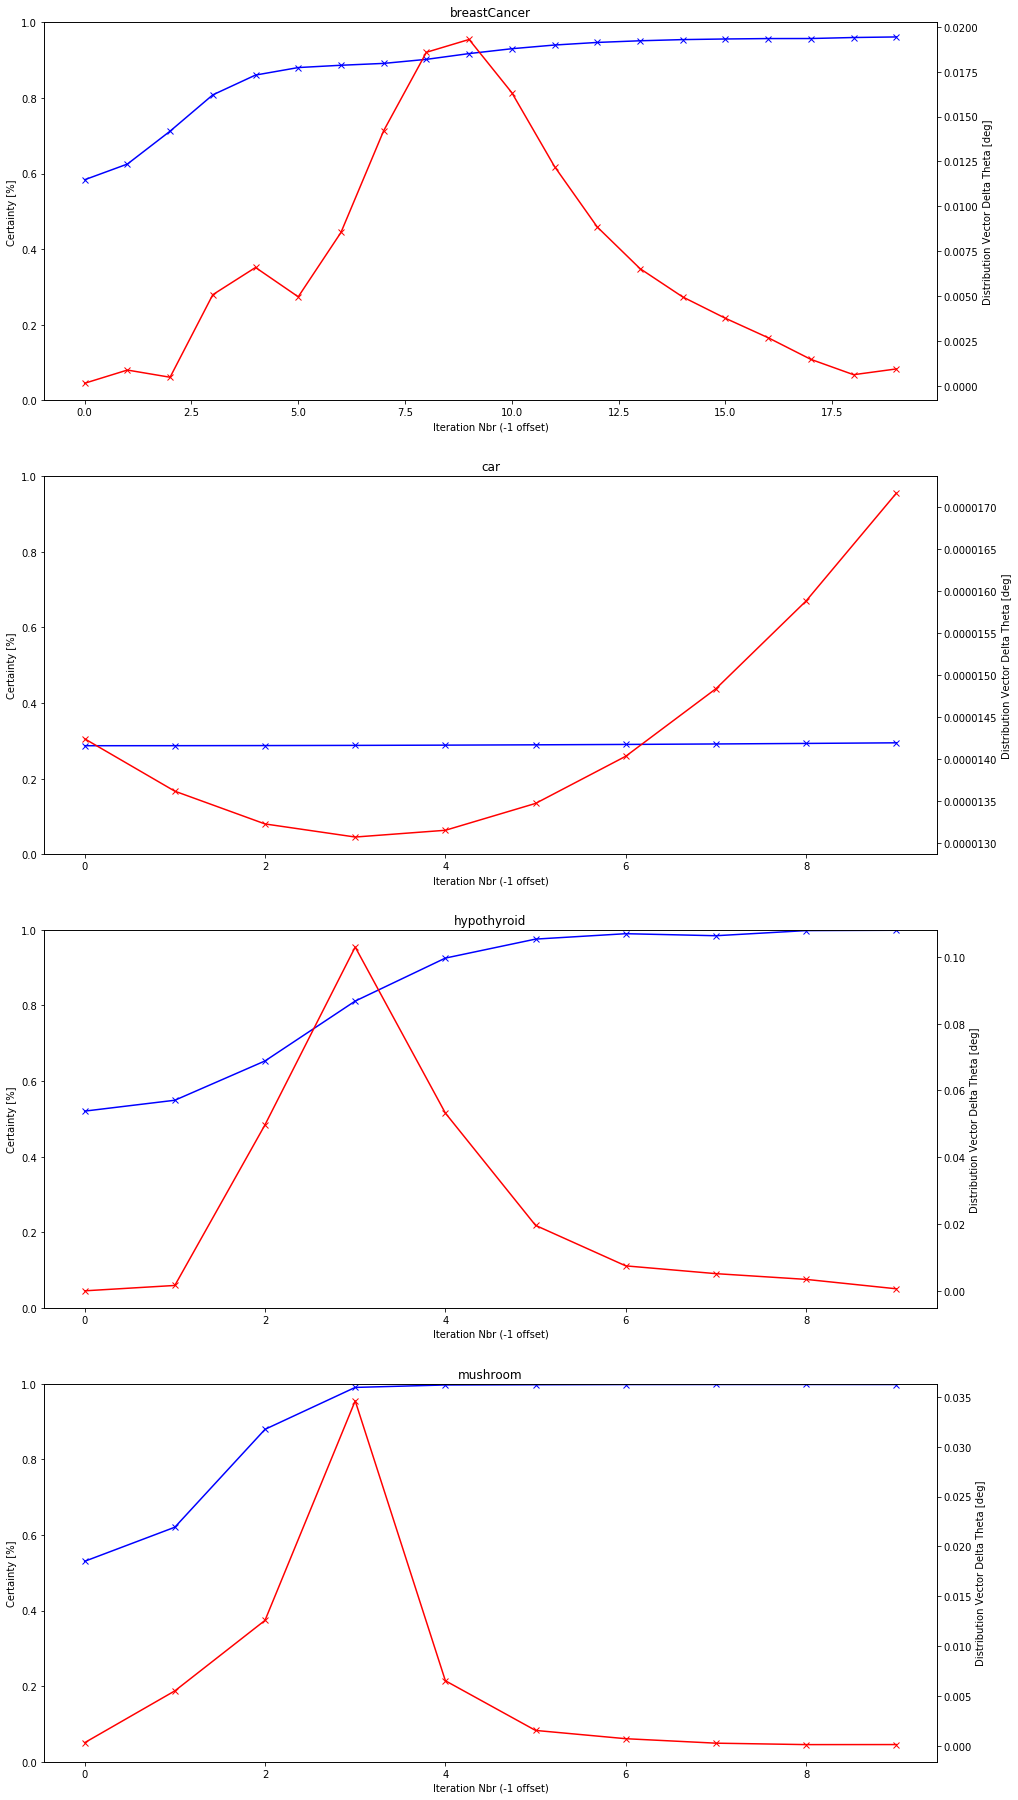


## Dataset Observations
Briefly some observations about the datasets are presented.

#### Breast Cancer
The breast cancer dataset has very little data (~280 instance) and few (9) attributes. Attributes have an average of about 5 possible values.

#### Car
The dataset is moderate size (~1700 instances) and has fewer (6) attributes with an average of about 3 possible attribute values. This dataset has four class values.

#### Hypothyroid
F-Score was not available due to a zero recall value. The class value/label distribution was ~95%, 5%. 

The hypothyroid dataset has many instances (~3000), many attributes (~18). Its attributes are mostly binary with only two possible attribute values. 

### Mushroom
The mushroom dataset has many attributes (22), is large (8000+ instances) and an average of ~5 attribute values per attributee. 

## Q1
#### What characteristics of the data cause it to work well with an unsupervsed model?

##### Breast Cancer
The breast cancer unsupervised model shows comparable performance to the supervised model. This dataset has high class value distribution (~75%, 25%) and higher attribute arity (~5). Unlike the hypothyroid dataset - each class value point cloud has a large enough mass to not be dominated by the other competing cloud. That is, both clouds have tighter laxation and thus are more sensitive to the attribute profiles of an instance. High arity complements this allowing for greater distinction of similarity between an instance and a point cloud (more detailes attribute profiles). We see the unsupervised model become certain after 20 iterations and its class value/label distribution become more settled. This suggests the point clouds were able to separate themselves from one another during training and that datasets with separable point clouds work better with unsupervised models. This separability increased with arity and the number of attributes - as the increase the size of the NDimensional space.

##### Hypothyroid
The unsupervised model shows zero recall for the 'hypothyroid' classification. The model settles with high certainty and little change in class label distribution between iterations. We also see zero recall for the supervised model. The poor performance of both models here could be due to the small number of instances with the 'hypothyroid' class value. (~5%, 95% initial class value distribution) This could be because the 'negative' class value point cloud has too higher laxation and overwhelms the 'hypothyroid' class value point cloud when making comparisions. 

We see every prediction for the 'hypothyroid' class is wrong in both models. This suggests that neither model learnt what 'hypothyroid' might look like and that a model, unsupervised or supervised, will need to see enough of a given class label (ie hypthyroid) to be able to learn what that class label is. Datasets characterized by balanced class value/label distributions should work better with an unsupervised classifier. 

This set has many attributes but they mostly of binary arity. With low arity, it's harder for a point cloud to have a distinct prototype and thus harder to measure similarity of an instance between one point cloud and the next making training harder. We should look then for datasets with higher arity when using an unsupervised model.

##### Car
The car dataset performs poorly The dataset class value distribution is ~(4%, 4%, 22%, 70%), it has few attributes and low arity but many class values. The smaller class value clouds will need to be more distinct from the larger ones for the classifier to assign to them - otherwise the laxation of the larger clouds will offset any similarity an instance has to a smaller cloud. The space in which the clouds exist is limited in this data set due to low arity and few attributes. This could cause point clouds to be crowded and poorly defined. The result is a model with low certainty, and poor performance. We can say that the point clouds of this dataset are not linearly separable and that the training set has an unbalanced class value distribution. Our observations here suggest that datasets characterized by fewer class labels and more attributes with higher arity are desirable for unuspervised models.

##### Mushroom
The unsupervised model for the mushroom dataset quickly converges on class value distribution with a high certainty. Confusingly though - we see better performance with fewer training iterations. The mushroom dataset has many attributes, high arity and a ~50/50 class value distribution. 

Based on our prior observations - this should be an optimal dataset for unsupervised learning. Although - observations show that it's performance is poor compared to the supervised model. The unsupervised model relies on the assumption that attributes are independant when making predictions. (the 'naive' assumption) Attributes of mushroom physiology could be related - and thus errors accumulate on every training iteration due to our naive assumption. Models produced with less training iterations rely less heavily on the 'naive' assumption. However, the competing element here is that more training iterations allow the unsupervised model to better learn class values. As a result, datasets characterized by interdependant attributes are less suited to an unsupervised model.

In summary, datasets with the following charachteristics are better suited to unsupervised Naive Bayes models;
* More attributes.
* Higher attribute arity.
* Datasets with better balanced actual class value distributions.
* Datasets where the assumption that attributes are not related holds. (This is important for NB too - but more important for UNB)
* Datasets with linearly separable class label point clouds.


## Q7
#### What causes the Unsupervised Model to converge and what is happening for convergence?

Graphs of training data are presented in the results above for inspecting convergence of the unsupervised model. Two metrics are used for evaluating how class value distributions change between iterations (Distribution Delta) and how stable the model is (Certainty)

1. Certainty (blue line) - Measures for each prediction that the model makes, how certain is it? The average certainty of the model applied to some dataset.
> where $x_i$ corresponds to an instance
> $$ certainty = \frac{\Sigma_{i=0}^N (max(p(x_i = classLabel)))}{N} $$
2. Change in class value distribution (red line) - measures how the class value distribution changes between iterations. This is the change in angle between the class value distribution vector of one iteration and the next.
> Where i corresponds to a class value/label, and $ d_i $ to the probability ratio for class label 'i'
>$$ \mathbf D = [d_0, d_1, .. d_i] $$
>
> Where j corresponds to a training iteration
>$$ \delta\theta_j = arcos( \frac{\mathbf{D}_{j-1} \cdot \mathbf{D}_j}{\mid\mid \mathbf{D}_j\mid\mid \mid\mid \mathbf{D}_{j-1}\mid\mid}) $$

If we define convergence as the settling of class label distribution.

Visualizing what is happening during the training - we have point clouds with each point having a weighting between zero and one for each possible class value. At first they are randomly weighted. Our (finite) NDimensional space is like a sponge filled with a coloured dye - one colour for each class value, and each point is the 'material' of the sponge. At the end of each iteration, the dispersal of the 'coloured dye' becomes more ordered (loses entropy). Initially the dyes are evenly dispersed (random probability distribution, high entropy). Ideally - each colour of dye will separate into it's own distinct region of the sponge, and there will be minimum overlap with other colours at it's boundary. So what causes the dye to lose entropy (become less random) for a training iteration and when does it settle (converge)? 

Considering an example with two class values. One theory is that - whichever point cloud is largest after random seeding will have a prototype close to the training set prototype but slightly different (random variation). Ditto for the other cloud however it will be smaller. The larger cloud will collect more points on the first training iteration than the other clouds (it has a higher laxation) and these points will be tend to be closer to it's prototype than the training set's average prototype. However it will be marginally less sensitive to the dis-similarity between points it collects and it's own prototype when compared the other point cloud (which has a slightly lower laxation due to it's smaller size). The other point cloud will have been more sensitive to differences in similarity between points and it's prototype. Thus it will have collected less points overall (because of it's lower laxation) but more points closer to it's own prototype. (greater point weightings actually but here linguistic precision is sacrificed for simplicity of explanation) 

At the end of the iteration, after accounting for the new point probability weightings, the larger cloud will tend to have an increased size (total class label probability weighting, due to its higher laxation) and the smaller cloud will tend to have a decresed size (lower total class label probability weighting due to it's lower laxation). The larger cloud will tend to have a minor overall shift of it's prototype point in the direction formed by a vector pointing from the origin to its original protoype point (it weakly preferred points with greater similarity to its prototype). The smaller cloud will have a greater shift of it's prototype point in the direction formed by a vector pointing from the origin to it's prototype point. (it more strongly preferred points with greater similarity to its protoype due to its lower laxation) As training iteration continue, this process will repeat and the dyes (point clouds) will draw apart. The more distinct the point clouds become - the lower the distribution delta and the higher the certainty. This due to a lessened interference/competition from neighbouring clouds (which are far away and have only dissimilar points.) 

When considering a single cloud (colour) - the dye stops changing its distribution when the laxation of a cloud and similarity of points in a cloud to the clouds prototype become balanced. When considering the dynamic between clouds, they become balanced when they become sufficiently distinct. 

Given the above, we hypothesize that convergence requires data be separable in n dimensional space into as many partitions as there are class labels and we require a balanced (guessed) starting label distribution that is random.

We observe high certainty and low distribution deltas in the graphs shown above for the breast cancer, hypothyroid and mushroom datasets. According to our theory - this means the point clouds were separable. All of these sets have a large NDimensional space (lots of attributes with high arity for breast cancer and mushrooms, lots of attributes for hypothyroid.) In contrast the graph above shows the car dataset has no increase in certainty and no sign of a decreasing distribution delta. This suggests its data was not separable. Consistent with this - we observed that the car dataset has few attributes and they are of low arity. 

A final comment is that convergence does not guarantee an optimal model. The mushroom results demonstrate this. A hypothesis is suggested for why this might be in the discussion for question one. (namely, each training iteration relies on the 'naive' assumption and errors accumulate). Consequently - there is a trade off between training iterations and lowering entropy. More training does not always result in a better unsupervised model.

In summary
* Larger clouds grow in an iteration with less sensitivity to dissimilaritys between new members and their prototype. 
* Smaller clouds shrink and more strongly prefer points more similar to their prototype. 
* Clouds tend to move in the direction of their prototypes each iteration.
* Clouds change (prototype location and laxation) untill a balance is struck between laxation and similarity of members to the cloud prototype. 
* Datasets need to be linearly seperable in their NDimensional space for convergence to occur.
* Convergence does not mean a model is optical. Less training can be better for datasets with highly related attributes.


## Code to generate graphs

In [64]:
# This is the code used to plot unsupervised training metric graphics.
import matplotlib.pyplot as pypl
def printTrainingConvergence():
    '''Print training iteration performance for any unsupervised data classifiers
    '''
    
    # Get figure to plot on
    NCOL = 1
    NROW = len(classifierObject)//NCOL
    fig, axes = pypl.subplots(NROW,NCOL, figsize=(16,32))
    fig.figsize=(10,10)
    px=0
    
    # Plot each dataset in classifier object
    for dataset in classifierObject.keys():
        
        classifier = classifierObject[dataset]['Unsupervised']
        trainingData = classifier.trainingMetrics
        #pprint(trainingData)
        datasetName = classifier.dataKey
        
        xtick = []
        metricName = list(trainingData[list(trainingData.keys())[0]].keys())
        y = [ [] for metric in metricName ]

        # Extract data
        for iteration in range(len(list(trainingData.keys()))):
            iterationkey = 'Iteration {}'.format((iteration+1))
            yx=0
            for metric in metricName:
                y[yx].append(trainingData[iterationkey][metric])
                yx+=1
        
        # Plot
        
        #axisLeft = axes[px//NCOL, (px%NCOL)]
        axisLeft=axes[px]
        axisLeft.set_ylim([0,1])
        axisRight = axisLeft.twinx()
        #axisRight.set_ylim([0,0.01])
        axisLeft.set_ylabel('Certainty [%]')
        axisLeft.set_xlabel('Iteration Nbr (-1 offset)')
        axisRight.set_ylabel('Distribution Vector Delta Theta [deg]')
            
        axisLeft.plot(range(len(y[0])),y[0], 'bx-', label=metricName[0])
        axisRight.plot(range(len(y[1])),y[1], 'rx-', label=metricName[1])

        axisLeft.set_title(datasetName)
            
        px+=1
    

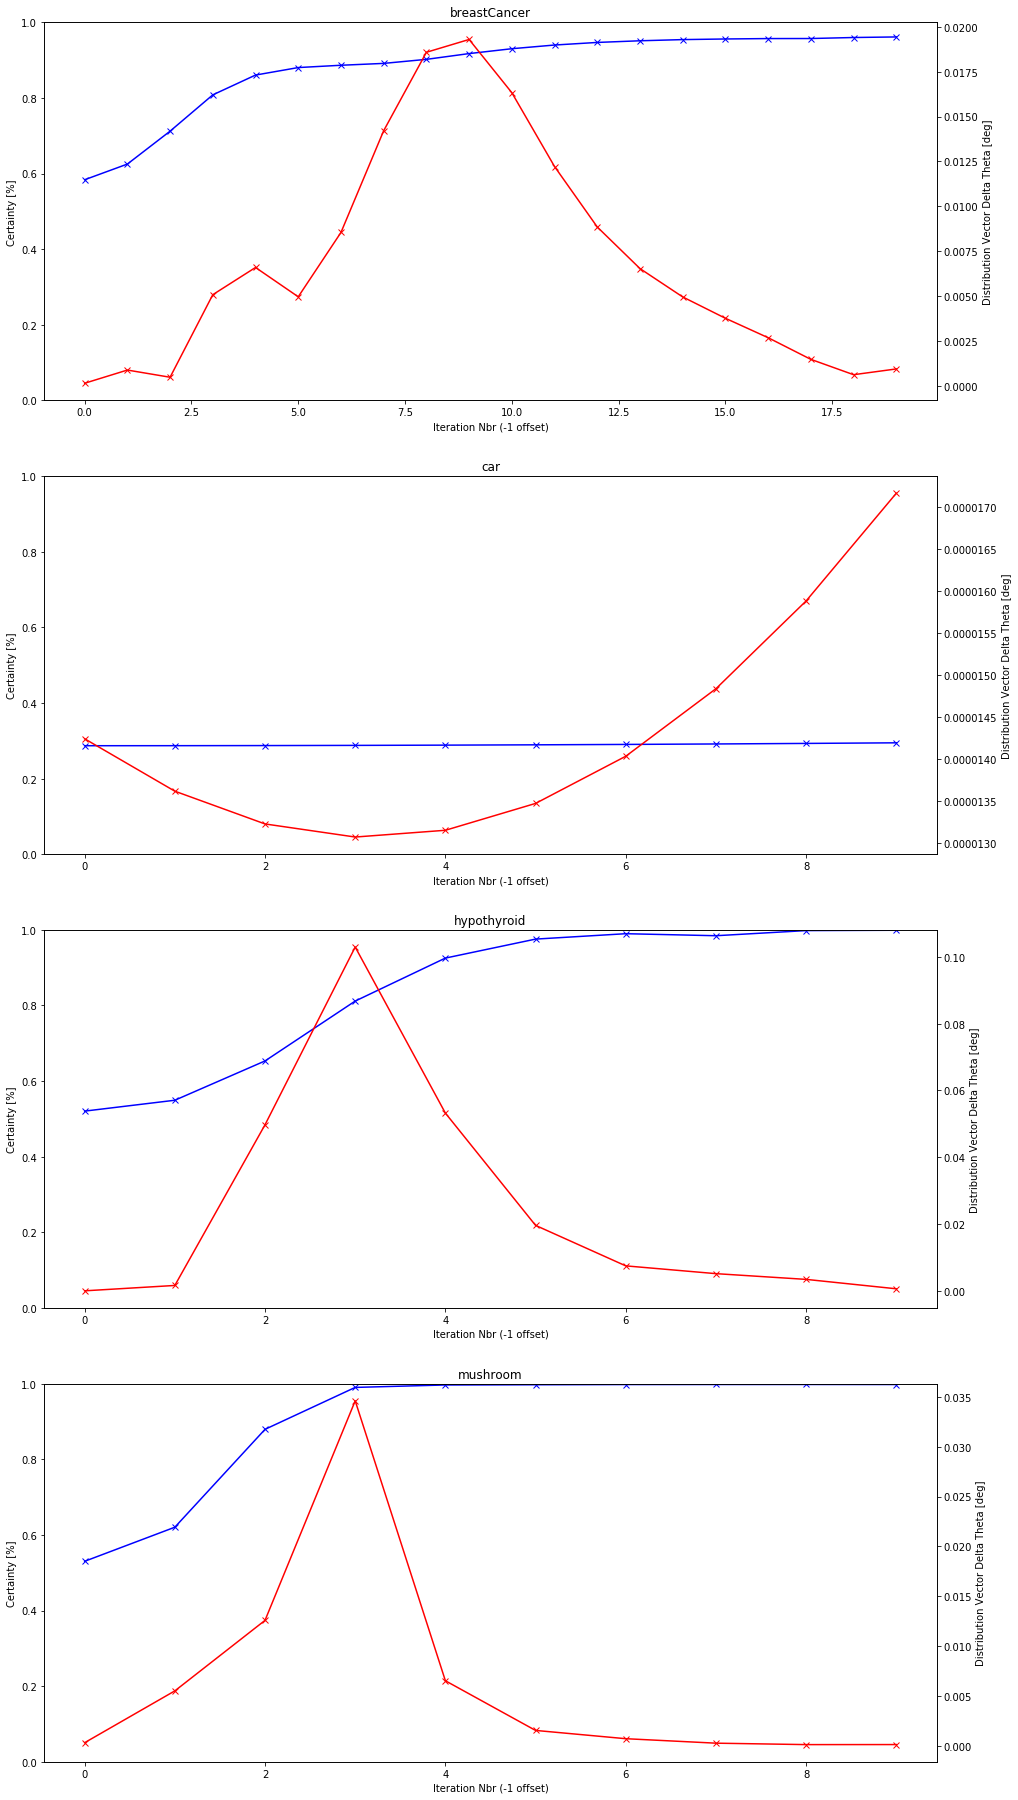

In [61]:
printTrainingConvergence()

## Code demonstrating more detailed evaluation metrics for hypothyroid

In [67]:
import pprint

pp=pprint.PrettyPrinter(indent=4)
#pp.pprint(classifierObject['mushroom']['Supervised'].model)
pp.pprint(classifierObject['hypothyroid']['Unsupervised'].metrics)

{   'Class Average': {   'Basic Class Accuracy': 88.24273072060683,
                         'Class Accuracy': 88.24273072060683,
                         'Class Error Rate': 11.757269279393173,
                         'Class F-Score': 'NA',
                         'Class Precision': 88.24273072060683,
                         'Class Recall': 45.68062827225131},
    'hypothyroid': {   'Basic Class Value Accuracy': 88.24273072060683,
                       'Class Value Accuracy': 88.24273072060683,
                       'Class Value Error Rate': 11.757269279393173,
                       'Class Value F-Score': 'NA',
                       'Class Value Precision': 88.24273072060683,
                       'Class Value Recall': 0.0,
                       'False Negative': 27,
                       'False Positive': 66,
                       'Smoothing Applied': True,
                       'Total Correct': 698,
                       'True Negative': 698,
                       'Tru